In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import glob
import numpy as np

## Import & combine generation and index data

In [2]:
def make_gen_index(data_folder, time='Monthly'):
    """
    Read and combine the state-level generation and index files
    
    inputs:
        data_folder: (str or path) path to the state-level data files
        time: (str) "Monthly", "Quarterly", or "Annual"
        
    outputs:
        gen_index: (df) a dataframe with combined generation and index data
    """
    
    index_path = os.path.join(data_folder, '{} index*'.format(time))
    gen_path = os.path.join(data_folder, '{} gen*'.format(time))
    
    # Get filenames and list of state abbreviations
    index_fns = glob.glob(index_path)
    gen_fns = glob.glob(gen_path)
    
    # Not sure why, but DC shows up in index but not gen
    index_states = [f.split('.')[0][-2:] for f in index_fns]
    gen_states = [f.split('.')[0][-2:] for f in gen_fns]
    
    
    # Read and combine files into single dataframes
    def read_combine(paths, states):
        df_list = []
        for f, state in zip(paths, states):
            df = pd.read_csv(f)
            df['State'] = state
            df_list.append(df)
        
        full_df = pd.concat(df_list)
        full_df.reset_index(inplace=True, drop=True)
        full_df.rename(columns={'year': 'Year'},
                       inplace=True)
        
        if 'datetime' in full_df.columns:
            full_df['datetime'] = pd.to_datetime(full_df['datetime'])
        
        return full_df
    
    index_df = read_combine(index_fns, index_states)
    gen_df = read_combine(gen_fns, gen_states)
    
#     return index_df, gen_df
    
    # Different timescales will pivot on different columns
    gen_pivot_col = {'Monthly': ['Year', 'datetime'],
                     'Quarterly': ['Year', 'year_quarter'],
                     'Annual': ['Year']}
    
    gen_pivot = pd.pivot_table(gen_df, index=['State'] + gen_pivot_col[time], 
                               values='generation (MWh)', columns='fuel category')
    gen_pivot.reset_index(inplace=True, drop=False)
#     gen_pivot['Year'] = gen_pivot['datetime'].dt.year
    gen_pivot.replace(np.nan, 0, inplace=True)
    
    # Merge gen and index dataframes
    merge_col = {'Monthly': ['datetime'],
                 'Quarterly': ['year_quarter'],
                 'Annual': ['Year']}
    
    gen_index = pd.merge(gen_pivot, index_df[merge_col[time] + ['State', 'index (g/kWh)', 'final CO2 (kg)']], 
                         on=merge_col[time] + ['State'])
    
    return gen_index

In [3]:
data_path = os.path.join('Data storage', 'final state data')
monthly_gen_index = make_gen_index(data_path, time='Monthly')
annual_gen_index = make_gen_index(data_path, time='Annual')

In [19]:
annual_gen_index.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),final CO2 (kg)
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,621.611811,4.192005e+09
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,565.861881,3.829370e+09
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,548.164631,3.474672e+09
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,535.042680,3.492072e+09
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,536.961208,3.531411e+09


In [21]:
fuels = ['Coal', 'Natural Gas', 'Other Renewables', 'Nuclear', 'Other',
         'Solar', 'Wind', 'Hydro']
annual_gen_index['Total gen'] = annual_gen_index.loc[:, fuels].sum(axis=1)
for fuel, new_col in zip(fuels, ['percent {}'.format(x) for x in fuels]):
    # Calculate percent of generation from each fuel type
    annual_gen_index[new_col] = (annual_gen_index.loc[:, fuel]
                                 / annual_gen_index.loc[:, 'Total gen'])

## State RPS information

In [7]:
path = os.path.join('Data storage', 'rps_compliance_data_july_2017.xlsx')
rps = pd.read_excel(path, header=35, parse_cols='A:V', na_values=['-'])

rps.index = rps.index.droplevel([1, 2])

rps.index.names = ['State', 'Type']

rps_tidy = pd.melt(rps.xs('Total RPS', level='Type').reset_index(), 
                   id_vars='State', var_name='Year', value_vars=rps.columns, 
                   value_name='Generation').dropna().sort_values(['State', 'Year'])

rps_start = {}
for state in rps_tidy['State'].unique():
    first_year = rps_tidy.loc[rps_tidy['State'] == state, 'Year'].min()
    rps_start[state] = first_year

In [8]:
rps_start

{'AZ': 2001,
 'CA': 2004,
 'CO': 2007,
 'CT': 2004,
 'DC': 2007,
 'DE': 2007,
 'HI': 2005,
 'IA': 1999,
 'IL': 2008,
 'KS': 2011,
 'MA': 2003,
 'MD': 2006,
 'ME': 2000,
 'MI': 2012,
 'MN': 2002,
 'MO': 2011,
 'MT': 2008,
 'NC': 2010,
 'NH': 2008,
 'NJ': 2001,
 'NM': 2006,
 'NV': 2003,
 'NY': 2006,
 'OH': 2009,
 'OR': 2011,
 'PA': 2006,
 'RI': 2007,
 'TX': 2002,
 'WA': 2012,
 'WI': 2000}

## Dumbell plot of annual state index

### Dumbell plot code
https://github.com/iturki/Data-Analysis-and-Visualization-Projects/blob/master/dumbbell-chart-python/dumbbbell_plot.py

In [15]:
sns.set()
sns.set_style('white')

This version of the plot is probably better/more flexible

In [9]:
def dumbell_plot(data, years, axis_labels, legend_loc=[], offset_divider=35,
                 rps_start={}, fig_kwargs={}, figsize=(5,9), legend=True,
                 text_h_align='right', palette='deep'):
    '''
    This is an example to create a dumbbell chart in Python.
    If you would like to provide your data and customize the graph, modify the variables in the section below.
    Please be aware that you need matplotlib installed in order for this to work.
    '''
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = sns.color_palette(palette)
    A_COLOR = colors[0] #'#EA2BA2'  # Color to plot a values
    B_COLOR = colors[2] #'#006666'  # Color to plot b values

    # Styles to be used when plotting the different elements of the graph.
    dumbbell_style_a = dict(color=A_COLOR, linewidths=2,# mec=A_COLOR,
                            marker='o', s=50)# markersize=9)
    dumbbell_style_b = dict(color=B_COLOR, linewidths=2,# mec=B_COLOR,
                            marker='o', s=50) #markersize=9)
    axis_label_style = dict(horizontalalignment=text_h_align,
                            verticalalignment='center', fontsize=10)
    
    data = data.loc[:, years]
    min_data = data.min(axis=1)
    max_data = data.max(axis=1)

    # Create the figure
    fig, ax = plt.subplots(figsize=figsize, **fig_kwargs)

    index = range(len(axis_labels))
    
    # Auto-set the state abbr text offset
    # The divider of 40 is based on the g/kWh figure max of 1185 and
    # offset of 30
    label_offset = data.max().max() / offset_divider
    
    # Loop N times
    for i, (data, year) in enumerate(zip(data.T.values, years)):
        color = colors[i]
        for value, label, j in zip(data, axis_labels, index):
            facecolor = None
            if label in rps_start and rps_start[label] <= year:
                facecolor = 'w'
            
            ax.scatter(value, j, facecolors=facecolor, zorder=3, color=color,
                      linewidth=2, s=50)
            
            plt.hlines(y=j, xmin=min_data[j], xmax=max_data[j], zorder=2)
            
            if i == 0:
                ax.text(min_data[j] - label_offset, j, label,
                        **axis_label_style)

    plt.yticks(index, ['' for x in axis_labels])

    if legend:
        for i, year in enumerate(years):
            ax.scatter(x=legend_loc[i], y=51, color=colors[i], zorder=3,
                       s=50, linewidth=2)
            plt.text(x=legend_loc[i], y=52, s=str(year), ha='center')
        plt.hlines(y=51, xmin=legend_loc[0], zorder=2, xmax=legend_loc[-1])
        

(-1, 53)

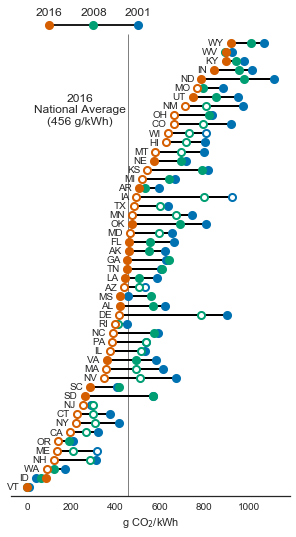

In [90]:
barbell_index = annual_gen_index.pivot_table(values='index (g/kWh)',
                                          index='State', columns='Year')
barbell_index.sort_values(by=2016, inplace=True)

index_2001 = barbell_index[2001]
index_2008 = barbell_index[2008]
index_2016 = barbell_index[2016]

# data = [barbell_index[year] for year in [2001, 2008, 2016]]
states_index = list(barbell_index.index)
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_index, [2001, 2008, 2016], states_index, legend_loc=[500, 300, 100],
             rps_start=rps_start, palette='colorblind')

plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
           linewidth=1)

# Lines for 2008 and 2001 national averages. I'm not sure that I like them,
# because they clutter up the figure.
# plt.vlines(582, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
#            linewidth=1)
# plt.vlines(631, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
#            linewidth=1)

plt.ylim(-1, 53)
plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('g CO$_2$/kWh')

In [10]:
barbell_index = annual_gen_index.pivot_table(values='index (g/kWh)',
                                          index='State', columns='Year')

In [12]:
barbell_index['change'] = barbell_index[2016] - barbell_index[2001]
barbell_index['% change'] = barbell_index['change'] / barbell_index[2001]

(-1, 53)

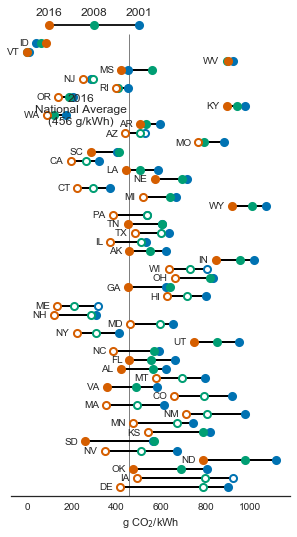

In [18]:
# barbell_index = annual_gen_index.pivot_table(values='index (g/kWh)',
#                                           index='State', columns='Year')
barbell_index.sort_values(by='change', inplace=True)

states_index = list(barbell_index.index)

dumbell_plot(barbell_index, [2001, 2008, 2016], states_index, legend_loc=[500, 300, 100],
             rps_start=rps_start, palette='colorblind')

plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
           linewidth=1)
plt.ylim(-1, 53)
plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('g CO$_2$/kWh')

In [34]:
year = annual_gen_index['Year']
index_order = annual_gen_index.loc[year == 2001].sort_values(by='percent Coal')['State'].values

In [36]:
index_order

array(['VT', 'RI', 'ID', 'CA', 'ME', 'AK', 'OR', 'WA', 'CT', 'HI', 'NJ',
       'NY', 'NH', 'LA', 'MA', 'FL', 'MS', 'TX', 'SC', 'IL', 'AZ', 'SD',
       'DE', 'VA', 'NV', 'AR', 'PA', 'AL', 'MD', 'MI', 'TN', 'NC', 'OK',
       'GA', 'MN', 'NE', 'WI', 'MT', 'KS', 'CO', 'MO', 'NM', 'IA', 'OH',
       'UT', 'IN', 'KY', 'ND', 'WY', 'WV'], dtype=object)

Order the states by percent generation from coal in 2008

(-1, 53)

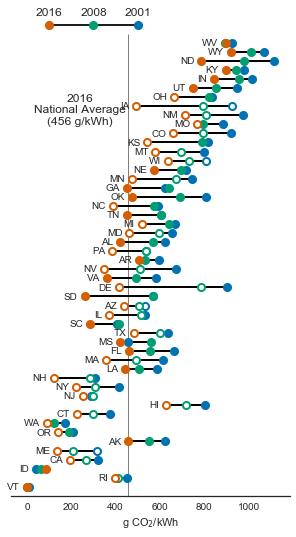

In [35]:
# barbell_index = annual_gen_index.pivot_table(values='index (g/kWh)',
#                                           index='State', columns='Year')
# barbell_index.sort_values(by='change', inplace=True)

states_index = list(index_order)

dumbell_plot(barbell_index.loc[index_order], [2001, 2008, 2016], states_index,
             legend_loc=[500, 300, 100], rps_start=rps_start,
             palette='colorblind')

plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
           linewidth=1)
plt.ylim(-1, 53)
plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('g CO$_2$/kWh')

### Annual emissions

In [4]:
total_emiss = annual_gen_index.groupby('Year')['final CO2 (kg)'].sum()

In [5]:
total_emiss

Year
2001    2.358643e+12
2002    2.381871e+12
2003    2.406899e+12
2004    2.391828e+12
2005    2.436053e+12
2006    2.386896e+12
2007    2.451643e+12
2008    2.397060e+12
2009    2.180317e+12
2010    2.308060e+12
2011    2.213991e+12
2012    2.084190e+12
2013    2.102480e+12
2014    2.098176e+12
2015    1.973093e+12
2016    1.867880e+12
2017    4.118497e+11
Name: final CO2 (kg), dtype: float64

In [12]:
half_states = {}
for year in range(2001, 2017):
    temp = annual_gen_index.loc[annual_gen_index['Year'] == year].copy()
    temp.sort_values(by='final CO2 (kg)', inplace=True)
    
    cumsum_emiss = temp['final CO2 (kg)'].cumsum()
    
    num_half = 50 - (cumsum_emiss <= total_emiss.loc[year]/2).sum()
    half_states[year] = list(temp.loc[~(cumsum_emiss <= total_emiss.loc[year]/2), 'State'].values)
    
    print('In {}, {} states contributed half the total emissions'.format(year, num_half))

In 2001, 11 states contributed half the total emissions
In 2002, 11 states contributed half the total emissions
In 2003, 11 states contributed half the total emissions
In 2004, 11 states contributed half the total emissions
In 2005, 11 states contributed half the total emissions
In 2006, 11 states contributed half the total emissions
In 2007, 11 states contributed half the total emissions
In 2008, 11 states contributed half the total emissions
In 2009, 11 states contributed half the total emissions
In 2010, 11 states contributed half the total emissions
In 2011, 10 states contributed half the total emissions
In 2012, 11 states contributed half the total emissions
In 2013, 11 states contributed half the total emissions
In 2014, 11 states contributed half the total emissions
In 2015, 11 states contributed half the total emissions
In 2016, 11 states contributed half the total emissions


In [15]:
half_states[2011].append(np.nan)

In [17]:
pd.DataFrame(half_states).to_clipboard()

In [31]:
list(set(half_states[2001]).intersection(set(half_states[2016])).intersection(set(half_states)))

['TX', 'OH', 'AL', 'WV', 'PA', 'IL', 'GA', 'IN', 'KY', 'FL']

In [35]:
list(set(x) for x in half_states.values())

[{'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'M

In [37]:
constant_states = set.intersection(*list(set(x) for x in half_states.values()))

In [42]:
constant_states

{'AL', 'FL', 'IL', 'IN', 'KY', 'OH', 'PA', 'TX'}

In [41]:
for year in range(2001, 2017):
    temp = annual_gen_index.loc[annual_gen_index['Year'] == year].copy()
    percent_emissions = (temp.loc[temp['State'].isin(constant_states), 'final CO2 (kg)'].sum()
                         / total_emiss.loc[year] * 100)
    print 'In {}, they were {:.1f}% of emissions'.format(year, percent_emissions)

In 2001, they were 41.5% of emissions
In 2002, they were 42.0% of emissions
In 2003, they were 42.0% of emissions
In 2004, they were 41.8% of emissions
In 2005, they were 42.0% of emissions
In 2006, they were 42.6% of emissions
In 2007, they were 42.0% of emissions
In 2008, they were 42.2% of emissions
In 2009, they were 42.3% of emissions
In 2010, they were 42.8% of emissions
In 2011, they were 43.8% of emissions
In 2012, they were 43.0% of emissions
In 2013, they were 43.1% of emissions
In 2014, they were 43.0% of emissions
In 2015, they were 41.9% of emissions
In 2016, they were 41.7% of emissions


In [33]:
print half_states[2001]
print half_states[2016]

153    GA
357    MI
816    WV
17     AL
272    KY
221    IL
629    PA
578    OH
238    IN
136    FL
714    TX
Name: State, dtype: object
32     AL
168    GA
406    MO
831    WV
236    IL
287    KY
593    OH
644    PA
253    IN
151    FL
729    TX
Name: State, dtype: object


In [11]:
annual_gen_index.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),final CO2 (kg)
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,621.611811,4.192005e+09
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,565.861881,3.829370e+09
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,548.164631,3.474672e+09
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,535.042680,3.492072e+09
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,536.961208,3.531411e+09


## Gross state product data

In [40]:
us_state_abbrev = {
    'United States': 'US',
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [73]:
path = os.path.join('Data storage', 'GDP data', 'gsp_naics_all_R', 'gsp_naics_all_R.csv')
gsp = pd.read_csv(path)
gsp = gsp.loc[gsp['IndustryId'] == 1]
gsp.drop(['GeoFIPS', 'Region', 'ComponentId', 'ComponentName', 'IndustryId',
          'IndustryClassification', 'Description'], axis=1, inplace=True)
gsp.rename(columns={'GeoName': 'State'}, inplace=True)
gsp = pd.melt(gsp, id_vars='State', var_name='Year', value_name='GSP')
gsp['State'] = gsp['State'].map(us_state_abbrev)

for col in ['Year', 'GSP']:
    gsp.loc[:, col] = pd.to_numeric(gsp.loc[:, col])

In [74]:
gsp.head()

,State,Year,GSP
0,US,1997,11118778
1,AL,1997,137143
2,AK,1997,37880
3,AZ,1997,163114
4,AR,1997,79164


Check to see what percent of GDP is generated in the highest emitting states that are responsible for at least half of US CO<sub>2</sub> emissions from electricity. The fraction is remarkably consistent over time (34-36%). Maybe not too surprising, given that the list of states is pretty stable. 

In [77]:
total_gsp = {}
half_states_gsp = {}
for year in half_states.keys():
    total_gsp[year] = gsp.loc[(gsp['Year'] == year) &
                              (gsp['State'] == 'US'), 'GSP'].sum()
                               
    half_states_gsp[year] = gsp.loc[(gsp['Year'] == year) &
                                    (gsp['State'].isin(half_states[year])), 'GSP'].sum()
                               
    percent = half_states_gsp[year] / total_gsp[year] * 100
                               
    print('In {}, states with half of emissions contributed to {:.1f}% of GDP'.format(year, percent))

NameError: name 'half_states' is not defined

In [78]:
annual_gen_index_gsp = annual_gen_index.merge(gsp, on=['State', 'Year'])

In [79]:
non_fuels = ['State', 'Year', 'index (g/kWh)', 'GSP']
gen_cols = [x for x in annual_gen_index.columns if x not in non_fuels]
total_gen = annual_gen_index.loc[:, gen_cols].sum(axis=1)

annual_gen_index_gsp.loc[:, 'tonne CO2/mmUSD'] = (annual_gen_index_gsp.loc[:, 'final CO2 (kg)']
                                                  / annual_gen_index_gsp.loc[:, 'GSP']
                                                  / 1000)

In [146]:
barbell_gsp.head()

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
State,,,,,,,,,,,,,,,,
VT,2.080719,0.604386,0.953365,0.808575,0.537677,0.402272,0.398129,0.290648,0.284273,0.325978,0.927531,0.476878,0.558136,0.522327,0.173791,0.036616
CA,39.200947,29.321641,27.569651,26.891922,23.534957,25.186866,27.702167,27.607846,26.708384,24.304318,20.284047,25.601103,24.413727,23.789937,22.222309,17.628087
ID,8.742748,9.478000,13.850141,14.064815,12.651810,10.156846,12.826733,13.270562,13.438802,13.236149,9.179855,14.835388,24.739240,18.120343,26.663683,22.561670
NY,55.892894,52.537022,52.933861,51.579257,50.814780,42.486970,43.882397,38.638995,30.782576,33.179353,29.841561,28.170799,26.943060,26.660672,25.523978,23.599729
WA,49.830116,40.056456,50.803696,48.257659,46.250038,30.287404,34.981199,37.457905,38.577325,39.539452,21.651052,17.800732,32.634542,30.873283,28.707404,24.202803


(-1, 53)

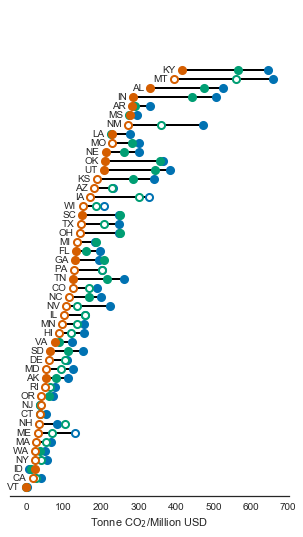

In [80]:
barbell_gsp = annual_gen_index_gsp.pivot_table(values='tonne CO2/mmUSD',
                                              index='State', columns='Year')
barbell_gsp.sort_values(by=2016, inplace=True)
barbell_gsp.drop(['WY', 'ND', 'WV'], inplace=True)

states_gsp = list(barbell_gsp.index)

dumbell_plot(barbell_gsp, [2001, 2008, 2016], states_gsp, offset_divider=40,
             rps_start=rps_start, legend=False, palette='colorblind')

plt.ylim(-1, 53)
sns.despine(left=True)
plt.xlabel('Tonne CO$_2$/Million USD')

(-1, 53)

(500, 2000)

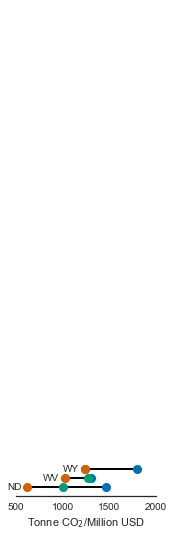

In [87]:
barbell_gsp = annual_gen_index_gsp.pivot_table(values='tonne CO2/mmUSD',
                                              index='State', columns='Year')
barbell_gsp.sort_values(by=2016, inplace=True)
barbell_gsp = barbell_gsp.loc[['ND', 'WV', 'WY']]

states_gsp = ['ND', 'WV', 'WY']

dumbell_plot(barbell_gsp, [2001, 2008, 2016], states_gsp, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind',
             figsize=(2.5, 9))

plt.ylim(-1, 53)
plt.xlim(500, 2000)
sns.despine(left=True)
plt.xlabel('Tonne CO$_2$/Million USD')

(-1, 50)

(8, 1950)

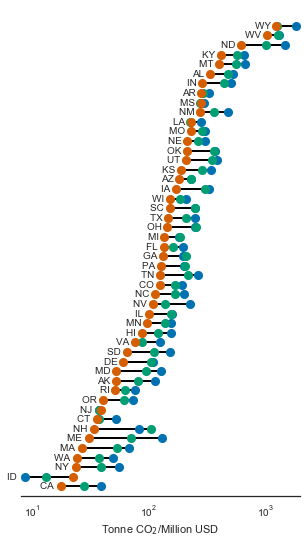

In [180]:
barbell_gsp = annual_gen_index_gsp.pivot_table(values='tonne CO2/mmUSD',
                                              index='State', columns='Year')
barbell_gsp.sort_values(by=2016, inplace=True)
barbell_gsp.drop('VT', inplace=True)

index_2001 = barbell_gsp[2001]
index_2008 = barbell_gsp[2008]
index_2016 = barbell_gsp[2016]

# data = [barbell_gsp[year] for year in [2001, 2008, 2016]]
states_gsp = ['{}  '.format(state) for state in barbell_gsp.index]
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_gsp, [2001, 2008, 2016], states_gsp, offset_divider=4000,
             rps_start=rps_start, legend=False, palette='colorblind')

# plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
#            linewidth=1)
plt.ylim(-1, 50)
# plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('Tonne CO$_2$/Million USD')
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim((8, 1950))

Are things changing because states got GSP changed or because electricity emissions changed. Scatter plot might be more appropriate. 

## Population

In [37]:
path = os.path.join('Data storage', 'Derived data', 'State population.csv')
pop = pd.read_csv(path)

In [38]:
pop.head()

,State,Year,Population
0,United States,2000,282162411
1,Alabama,2000,4452173
2,Alaska,2000,627963
3,Arizona,2000,5160586
4,Arkansas,2000,2678588


In [41]:
pop['State'] = pop['State'].map(us_state_abbrev)

In [42]:
pop.head()

,State,Year,Population
0,US,2000,282162411
1,AL,2000,4452173
2,AK,2000,627963
3,AZ,2000,5160586
4,AR,2000,2678588


In [44]:
annual_gen_index_pop = annual_gen_index.merge(pop, on=['State', 'Year'])

In [45]:
annual_gen_index_pop.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,...,Total gen,percent Coal,percent Natural Gas,percent Other Renewables,percent Nuclear,percent Other,percent Solar,percent Wind,percent Hydro,Population
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,...,6743766.00,0.083721,0.577655,0.000000,0.0,0.138942,0.0,0.000141,0.199542,633714
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,...,6767322.00,0.085009,0.558295,0.001796,0.0,0.142208,0.0,0.000000,0.212691,642337
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,...,6338738.00,0.086715,0.529204,0.000912,0.0,0.133508,0.0,0.000000,0.249661,648414
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,...,6526716.92,0.099434,0.555169,0.001412,0.0,0.114463,0.0,0.000000,0.229521,659286
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,...,6576658.54,0.094929,0.566188,0.000799,0.0,0.115397,0.0,0.000090,0.222597,666946


In [46]:
annual_gen_index_pop['tonne CO2/pop'] = (annual_gen_index_pop['final CO2 (kg)']
                                         / 1000
                                         / annual_gen_index_pop['Population'])
annual_gen_index_pop['MWh/pop'] = (annual_gen_index_pop.loc[:, 'Coal':'Wind'].sum(axis=1)
                                         / annual_gen_index_pop['Population'])

In [47]:
annual_gen_index_pop.describe(percentiles=[.1, .25])

,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),...,percent Natural Gas,percent Other Renewables,percent Nuclear,percent Other,percent Solar,percent Wind,percent Hydro,Population,tonne CO2/pop,MWh/pop
count,800.000000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,800.000000,...,800.000000,800.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000,8.000000e+02,800.000000,800.000000
mean,2008.500000,3.550089e+07,5.322606e+06,1.895001e+07,1.579629e+07,1.626548e+06,1.434886e+06,1.819396e+05,1.716463e+06,556.785176,...,0.217832,0.022560,0.171222,0.035361,2.232265e-03,0.024889,0.097672,6.082017e+06,10.849586,16.850713
std,4.612656,3.516025e+07,1.248921e+07,3.530107e+07,2.040010e+07,4.144479e+06,2.725588e+06,1.388029e+06,4.585832e+06,246.924591,...,0.226154,0.037475,0.180872,0.111552,1.016451e-02,0.050563,0.179955,6.718427e+06,13.640086,13.066728
min,2001.000000,0.000000e+00,0.000000e+00,-5.114000e+01,0.000000e+00,-9.925681e+05,-8.372700e+02,-5.000000e+00,0.000000e+00,0.577423,...,-0.000002,-0.000012,0.000000,-0.009830,-1.341994e-08,0.000000,0.000000,4.946570e+05,0.001609,2.780122
10%,2002.000000,6.239303e+05,3.198400e+04,2.864023e+05,0.000000e+00,4.696173e+03,5.576302e+03,0.000000e+00,0.000000e+00,214.701545,...,0.006596,0.000142,0.000000,0.000274,0.000000e+00,0.000000,0.000670,8.438739e+05,1.971700,7.319306
25%,2004.750000,4.274905e+06,5.544425e+05,1.767547e+06,0.000000e+00,6.290603e+04,1.045773e+05,0.000000e+00,0.000000e+00,412.240404,...,0.031917,0.002519,0.000000,0.001672,0.000000e+00,0.000000,0.008905,1.800205e+06,3.964499,9.959396
50%,2008.500000,2.838778e+07,1.425966e+06,6.750136e+06,9.341989e+06,4.325305e+05,7.226318e+05,0.000000e+00,6.193089e+04,554.814920,...,0.140771,0.013738,0.126436,0.006010,0.000000e+00,0.001618,0.023205,4.353254e+06,7.777610,14.516478
max,2016.000000,1.578965e+08,9.181770e+07,2.377314e+08,9.824031e+07,4.362692e+07,1.911608e+07,2.743193e+07,5.755051e+07,1113.788927,...,0.989443,0.274104,0.807704,0.827508,1.322405e-01,0.366584,0.896023,3.925002e+07,96.746995,90.521185


(-1, 53)

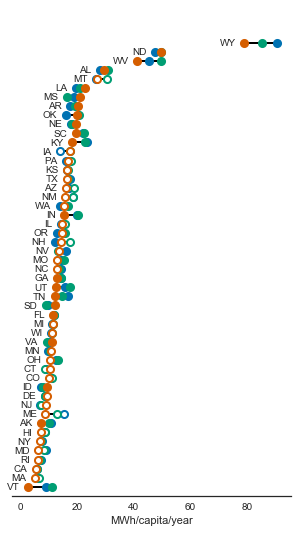

In [197]:
barbell_pop = annual_gen_index_pop.pivot_table(values='MWh/pop',
                                              index='State', columns='Year')
barbell_pop.sort_values(by=2016, inplace=True)
# barbell_pop.drop('VT', inplace=True)

# data = [barbell_pop[year] for year in [2001, 2008, 2016]]
states_pop = list(barbell_pop.index)
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2016], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind')

# plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
#            linewidth=1)
plt.ylim(-1, 53)
# plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('MWh/capita/year')
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')

(-1, 53)

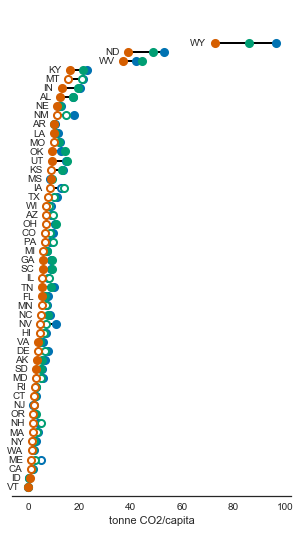

In [48]:
barbell_pop = annual_gen_index_pop.pivot_table(values='tonne CO2/pop',
                                              index='State', columns='Year')
barbell_pop.sort_values(by=2016, inplace=True)
# barbell_pop.drop('VT', inplace=True)

# data = [barbell_pop[year] for year in [2001, 2008, 2016]]
states_pop = list(barbell_pop.index)
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2016], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind')

# plt.vlines(456, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
#            linewidth=1)
plt.ylim(-1, 53)
# plt.text(x=240, y=40, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
plt.xlabel('tonne CO2/capita')
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')

(-1, 53)

(-1.5040565353615745, 25)

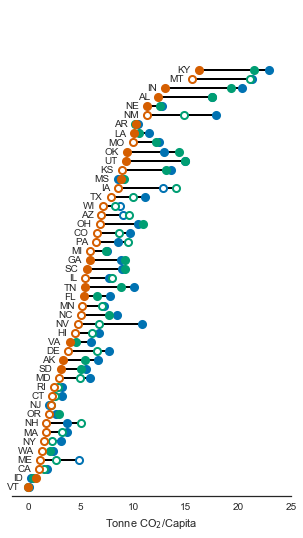

In [71]:
barbell_pop = annual_gen_index_pop.pivot_table(values='tonne CO2/pop',
                                              index='State', columns='Year')
barbell_pop.sort_values(by=2016, inplace=True)
barbell_pop.drop(['WY', 'ND', 'WV'], inplace=True)

# states_pop = ['{}  '.format(x) for x in barbell_pop.index]
states_pop = list(barbell_pop.index)
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2016], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind')

plt.ylim(-1, 53)
plt.xlim(None, 25)

sns.despine(left=True)
plt.xlabel('Tonne CO$_2$/Capita')
# plt.tight_layout()
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')

(-1, 53)

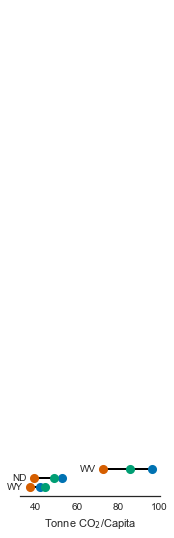

In [75]:
barbell_pop = annual_gen_index_pop.pivot_table(values='tonne CO2/pop',
                                              index='State', columns='Year')
barbell_pop.sort_values(by=2016, inplace=True)
barbell_pop = barbell_pop.loc[['WV', 'ND', 'WY']]

states_pop = ['WY', 'ND', 'WV']
# rps_states = list(rps_tidy['State'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2016], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind',
             figsize=(2.5, 9))

plt.ylim(-1, 53)
# plt.xlim(None, 25)

sns.despine(left=True)
plt.xlabel('Tonne CO$_2$/Capita')
# plt.tight_layout()
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')

## State electricity imports/exports
Data is from [EIA State Energy Data System](https://www.eia.gov/state/seds/seds-data-complete.php?sid=US#Consumption). 2016 Estimates will be available in October 2017. Code are described in [EIA documentation](https://www.eia.gov/state/seds/sep_use/notes/use_a.pdf). Negative values indicate flows out of the state.

In [152]:
path = os.path.join('Data storage', 'State energy flows', 'use_all_phy.csv')
flows = pd.read_csv(path)
flows = flows.loc[flows['MSN'] == 'ELISP']
flows.drop([str(x) for x in range(1960, 2001)], axis=1, inplace=True)
flows.drop(['Data_Status', 'MSN'], axis=1, inplace=True)

# Electricity flows are given in million kWh (see documentation)
flows.loc[:, '2001':] *= 1000

In [153]:
flows = flows.melt(id_vars='State', var_name='Year',
                   value_name='MWh flow')
flows['Year'] = flows['Year'].astype(int)

In [154]:
flows.head()

,State,Year,MWh flow
0,AK,2001,0
1,AL,2001,-35006000
2,AR,2001,-666000
3,AZ,2001,-23621000
4,CA,2001,75510000


In [179]:
annual_gen_index_pop_flows = pd.merge(annual_gen_index_pop, flows, on=['State', 'Year'])
annual_gen_index_pop_flows['MWh flow/pop'] = (annual_gen_index_pop_flows['MWh flow']
                                          / annual_gen_index_pop_flows['Population'])
annual_gen_index_pop_flows['share flow'] = (annual_gen_index_pop_flows['MWh/pop']
                                          / annual_gen_index_pop_flows['MWh flow/pop'])

In [180]:
annual_gen_index_pop_flows.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,...,percent Other,percent Solar,percent Wind,percent Hydro,Population,tonne CO2/pop,MWh/pop,MWh flow,MWh flow/pop,share flow
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,...,0.138942,0.0,0.000141,0.199542,633714,6.614979,10.641655,0,0.0,inf
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,...,0.142208,0.0,0.000000,0.212691,642337,5.961621,10.535470,0,0.0,inf
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,...,0.133508,0.0,0.000000,0.249661,648414,5.358724,9.775757,0,0.0,inf
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,...,0.114463,0.0,0.000000,0.229521,659286,5.296748,9.899675,0,0.0,inf
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,...,0.115397,0.0,0.000090,0.222597,666946,5.294897,9.860856,0,0.0,inf


(-1, 53)

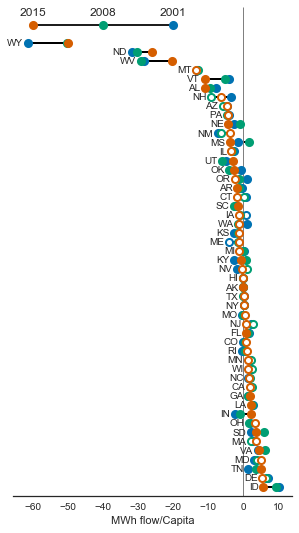

In [185]:
barbell_flows = annual_gen_index_pop_flows.pivot_table(values='MWh flow/pop',
                                              index='State', columns='Year')
barbell_flows.sort_values(by=2015, ascending=False, inplace=True)
# barbell_flows.drop('VT', inplace=True)

states_flows = list(barbell_flows.index)

dumbell_plot(barbell_flows, [2001, 2008, 2015], states_flows, offset_divider=8,
             rps_start=rps_start, legend=True, palette='colorblind',
             legend_loc=[-20, -40, -60])

plt.ylim(-1, 53)
sns.despine(left=True)
plt.xlabel('MWh flow/Capita')
plt.vlines(0, -1, 53, colors=['0.5'], linewidth=1)
# plt.xticks()
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')

In [186]:
annual_gen_index_pop_flows.describe()

,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),...,percent Other,percent Solar,percent Wind,percent Hydro,Population,tonne CO2/pop,MWh/pop,MWh flow,MWh flow/pop,share flow
count,750.000000,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,7.500000e+02,750.000000,...,750.000000,7.500000e+02,750.000000,750.000000,7.500000e+02,750.000000,750.000000,7.500000e+02,750.000000,750.000000
mean,2008.000000,3.621421e+07,5.324904e+06,1.837333e+07,1.577561e+07,1.677821e+06,1.424305e+06,1.197318e+05,1.528495e+06,563.452002,...,0.036107,1.427088e-03,0.021959,0.097660,6.057556e+06,10.994184,16.908805,-2.433827e+05,-2.645003,inf
std,4.323377,3.559621e+07,1.249540e+07,3.483507e+07,2.033529e+07,4.253015e+06,2.724845e+06,9.863566e+05,4.046065e+06,247.131923,...,0.112671,7.169996e-03,0.045151,0.180638,6.684421e+06,13.746515,13.117226,2.291679e+07,10.107309,NaN
min,2001.000000,0.000000e+00,0.000000e+00,-5.114000e+01,0.000000e+00,-9.925681e+05,-8.372700e+02,-5.000000e+00,0.000000e+00,0.996470,...,-0.009830,-1.341994e-08,0.000000,0.000000,4.946570e+05,0.007559,3.252542,-6.790100e+07,-61.493115,-3251.028410
25%,2004.000000,4.401219e+06,5.509728e+05,1.700621e+06,0.000000e+00,6.462725e+04,1.036491e+05,0.000000e+00,0.000000e+00,415.481460,...,0.001734,0.000000e+00,0.000000,0.009010,1.797654e+06,4.048936,9.981312,-9.621750e+06,-3.066595,-4.774674
50%,2008.000000,2.884501e+07,1.422502e+06,6.534177e+06,9.330993e+06,4.444923e+05,7.191269e+05,0.000000e+00,4.928850e+04,561.920185,...,0.006158,0.000000e+00,0.001279,0.023205,4.332868e+06,7.864837,14.543854,0.000000e+00,0.000000,1.134967
75%,2012.000000,5.172627e+07,3.387757e+06,1.765970e+07,2.805020e+07,1.417042e+06,1.751248e+06,2.076642e+03,1.163501e+06,743.697063,...,0.021770,4.013990e-05,0.021524,0.069361,6.748240e+06,12.243678,18.052115,1.132125e+07,2.027638,7.610533
max,2015.000000,1.578965e+08,9.181770e+07,2.377314e+08,9.785790e+07,4.362692e+07,1.911608e+07,2.082866e+07,4.483337e+07,1113.788927,...,0.827508,1.027469e-01,0.315214,0.896023,3.899394e+07,96.746995,90.521185,9.021000e+07,10.371511,inf


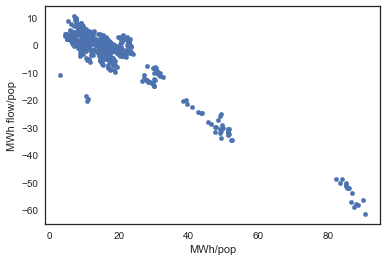

In [175]:
# g = sns.FacetGrid(annual_gen_index_pop_flows)
# g.map(plt.scatter)

# plt.scatter(x='MWh/pop', y='MWh flow/pop', data=annual_gen_index_pop_flows)
annual_gen_index_pop_flows.plot.scatter(x='MWh/pop', y='MWh flow/pop')

In [176]:
from scipy import stats
x = annual_gen_index_pop_flows['MWh/pop']
y = annual_gen_index_pop_flows['MWh flow/pop']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [178]:
slope, intercept, r_value

(-0.72283194161744402, 9.5772213797742545, -0.93808849183481346)

## Other analysis

In [10]:
pop.head()

,State,Year,Population
0,US,2000,282162411
1,AL,2000,4452173
2,AK,2000,627963
3,AZ,2000,5160586
4,AR,2000,2678588


In [11]:
gsp.head()

,State,Year,GSP
0,US,1997,11118778
1,AL,1997,137143
2,AK,1997,37880
3,AZ,1997,163114
4,AR,1997,79164


In [12]:
annual_gen_index.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),final CO2 (kg)
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,621.611811,4.192005e+09
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,565.861881,3.829370e+09
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,548.164631,3.474672e+09
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,535.042680,3.492072e+09
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,536.961208,3.531411e+09


In [190]:
total_gen = pd.DataFrame(columns=['Generation', 'State', 'Year', 'index (g/kWh)'])

total_gen['Generation'] = annual_gen_index.loc[:, 'Coal':'Wind'].sum(axis=1)
total_gen['State'] = annual_gen_index.loc[:, 'State']
total_gen['Year'] = annual_gen_index.loc[:, 'Year']
total_gen['index (g/kWh)'] = annual_gen_index.loc[:, 'index (g/kWh)']

In [191]:
total_gen.head()

,Generation,State,Year,index (g/kWh)
0,6743766.00,AK,2001,621.611811
1,6767322.00,AK,2002,565.861881
2,6338738.00,AK,2003,548.164631
3,6526716.92,AK,2004,535.042680
4,6576658.54,AK,2005,536.961208


In [192]:
total_gen_pop = pd.merge(total_gen, pop, on=['State', 'Year'])
total_gen_pop_gsp = pd.merge(total_gen_pop, gsp, on=['State', 'Year'])

In [193]:
total_gen_pop_gsp.head()

,Generation,State,Year,index (g/kWh),Population,GSP
0,6743766.00,AK,2001,621.611811,633714,37102
1,6767322.00,AK,2002,565.861881,642337,38605
2,6338738.00,AK,2003,548.164631,648414,38262
3,6526716.92,AK,2004,535.042680,659286,39648
4,6576658.54,AK,2005,536.961208,666946,40767


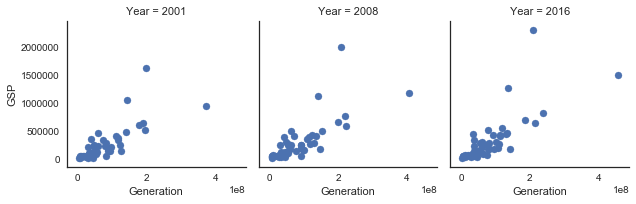

In [194]:
temp = total_gen_pop_gsp.loc[total_gen_pop_gsp['Year'].isin([2001, 2008, 2016])]

g = sns.FacetGrid(temp, col='Year')
g.map(plt.scatter, 'Generation', 'GSP')

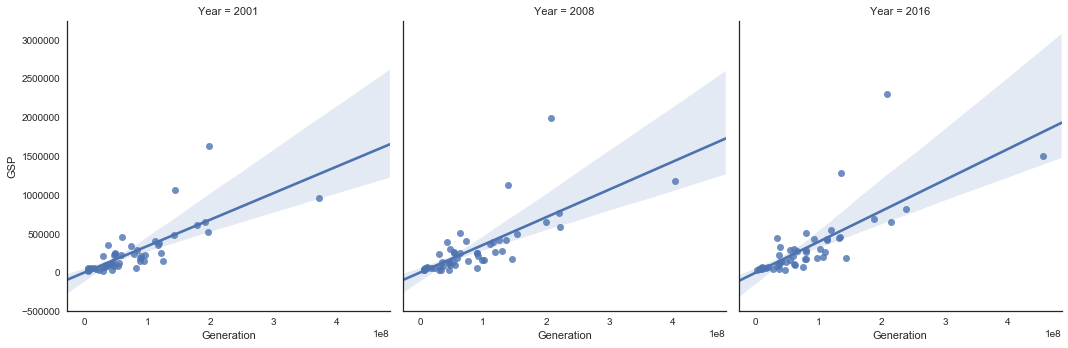

In [197]:
sns.lmplot(x='Generation', y='GSP', data=temp, col='Year')

In [187]:
import plotly.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

In [188]:
cf.go_offline(connected=True)

In [198]:
grid = ff.create_facet_grid(temp, x='Generation', y='GSP', facet_col='Year',
                           color_name='Year', color_is_cat=True)

iplot(grid)

In [195]:
temp['State/Year'] = temp.apply(lambda row: row['State'] + ' {}'.format(row['Year']), axis=1)
temp.iplot(kind='scatter', mode='markers', x='Generation', y='GSP', text='State/Year',
           xTitle='Generation (MWh)', yTitle='Gross State Product')

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [196]:
temp['State/Year'] = temp.apply(lambda row: row['State'] + ' {}'.format(row['Year']), axis=1)
temp.iplot(kind='scatter', mode='markers', x='Generation', y='Population', text='State/Year',
           xTitle='Generation (MWh)', yTitle='Population')

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

